<a href="https://colab.research.google.com/github/Stevenjr98/Image-classification-model-Cifar-10-/blob/main/enhanced_model_v1(batch_norm%2Bdynamic_lr).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# author: Stevenn
# date  : 2021-8-16
# model_v1
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import PIL
import numpy as np
import os
from tensorflow.keras import datasets, layers, models
import cv2 as cv
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

In [ ]:
DataSet = tf.keras.datasets.cifar10

(train_image,train_label),(test_image,test_label) = DataSet.load_data()

class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

170508288/170498071 [==============================] - 6s 0us/step


In [ ]:
#train_image = train_image/255.0
#test_image = test_image/255.0

mean = np.mean(train_image,axis=(0,1,2,3))
std = np.std(train_image,axis=(0,1,2,3))
train_image = (train_image-mean)/(std+1e-7)
test_image = (test_image-mean)/(std+1e-7)

In [ ]:
#rotation
data_augmentation = tf.keras.Sequential([
     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
#resize
IMG_SIZE = 180

resize_and_scale = tf.keras.Sequential([
     layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE),
     layers.experimental.preprocessing.Rescaling(1./255.0)
])

In [ ]:
#enhance
enhanced_img = tf.keras.Sequential([
     layers.experimental.preprocessing.Normalization(axis=-1,mean=None)
])

In [ ]:
# lr for large epoch
epoch = 300
learning_rate = 0.001
def scheduler(epoch):
    if epoch < 100:
        return learning_rate * 0.1
    if epoch < 200:
        return learning_rate * 0.01
    return learning_rate * 0.05

In [ ]:
# lr for small epoch
epoch = 300
learning_rate = 0.005
def scheduler(epoch):
    if epoch < 100:
        return learning_rate * 0.2
    if epoch < 300:
        return learning_rate * 0.02
    return learning_rate * 0.05

In [ ]:
#formal_model_v1
model = tf.keras.Sequential([
   #resize_and_scale,
   data_augmentation,
   #enhanced_img,
   layers.Conv2D(64,(3,3),activation='ELU',input_shape=(32,32,3)),
   #layers.MaxPooling2D((2,2)),
   layers.Conv2D(64, (3, 3), activation='ELU'),
   layers.BatchNormalization(axis=1),
   #池化
   layers.MaxPooling2D((2,2)),
   #norm = tf.nn.lrn(poola,4,bias=1,alpha=1,beta=0.5,name = 'normal'),
   layers.Conv2D(128, (3, 3), activation='PReLU'),
   layers.BatchNormalization(axis=1),
   layers.MaxPooling2D((2,2)),
   layers.Conv2D(256, (3, 3), activation='relu'),
   layers.BatchNormalization(axis=1),
   layers.MaxPooling2D((2,2)),
   #layers.AveragePooling2D(2,2), 
   layers.Dropout(rate=0.5),
   layers.Flatten(),
   layers.Dense(1024, activation='relu'),
   layers.Dense(10,activation='softmax'),                       
])
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'],
)

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
change_Lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

cp=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

In [ ]:
history = model.fit(train_image, train_label, epochs=500, batch_size = 32, 
                    validation_data=(test_image, test_label),
                    callbacks=[cp,change_Lr]
                    )

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 64)       112       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)      

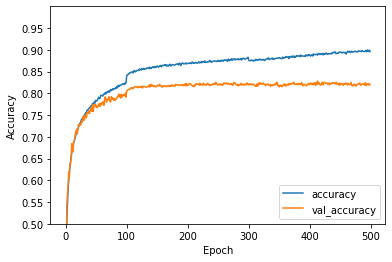

313/313 - 1s - loss: 0.5859 - accuracy: 0.8211 - 910ms/epoch - 3ms/step


In [ ]:
#准确率视图
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
y_ticks = np.arange(0.5,1,0.05)
plt.yticks(y_ticks)
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(test_image,  test_label, verbose=2)

In [ ]:
#保存模型
#model.save('/saved_model/my_model')

In [ ]:
# #second_model(loaded)
# model.load_weights(checkpoint_path)

In [ ]:
# #dynamic lr for model_v2
# def lr_shedule(epoch):
#   lrate = 0.001
#   if epoch > 125:
#     lrate = 0.0005
#   if epoch > 200:
#     lrate = 0.0003
#   return lrate

In [ ]:
#model_v2
# weight_decay = 1e-4

# model = tf.keras.Sequential([
#     data_augmentation,
#     #enhanced_img,
#     layers.Conv2D(32,(3,3),activation='ELU',padding = 'same',kernel_regularizer=keras.regularizers.l2(weight_decay),input_shape=train_image.shape[1:]),
#     layers.BatchNormalization(axis=1),
#     layers.Conv2D(32,(3,3),activation='ELU',padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)),
#     layers.BatchNormalization(axis=1),
#     layers.MaxPooling2D((2,2)),
#     layers.Dropout(rate=0.3),
#     layers.Conv2D(64,(3,3),activation='ELU'),
#     layers.BatchNormalization(axis=1),
#     layers.Conv2D(64,(3,3),activation='ELU'),
#     layers.BatchNormalization(axis=1),
#     layers.MaxPooling2D((2,2)),
#     layers.Dropout(rate=0.4),
#     layers.Conv2D(128,(3,3),activation='ELU'),
#     layers.BatchNormalization(axis=1),
#     layers.Conv2D(128,(3,3),activation='ELU'),
#     layers.BatchNormalization(axis=1),
#     layers.MaxPooling2D((2,2)),
#     layers.Dropout(rate=0.5),
#     layers.Flatten(),
#     #layers.Dense(1024, activation='relu'),
#     layers.Dense(10,activation='softmax') 
# ])
# model.compile(
#     optimizer = tf.keras.optimizers.Adam(lr=0.001,decay=1e-6),
#     loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics = ['accuracy'],
# )
# checkpoint_path = "training_2/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# change_Lr = tf.keras.callbacks.LearningRateScheduler(lr_shedule)

# cp=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

In [ ]:
# #new data_augmentation
# datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
#     )
# datagen.fit(train_image)

In [ ]:
# history = model.fit( #datagen.flow(train_image, train_label, batch_size=64),
#                      train_image,train_label,batch_size = 64,
#                      epochs=300,                                      
#                      validation_data=(test_image, test_label),
#                      callbacks=[change_Lr]
#                     )

In [ ]:
# model.summary()